In [1]:
import os

import optuna
from optuna.trial import TrialState

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pylab as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [57]:
# initialize lists of features
FINANCIAL_FEATURES = ['RSI', 'RSI_Gold', 'RSI_SP500', 'Daily_Change_Perc_SP500',
                            'Daily_Change_Perc_Gold','wpr', 'MACD', 'PROC_3', 'streak']

SENTIMENT_FEATURES = ['compound_weighted_avg7', 'compound_weighted',    'likes_count_daily_diff',
                            'retweets_count_weekly_diff', 'likes_count_avg7',
                            'goog_trend_score','neg_weighted', 'neg_weighted_avg7',
                            'pos_weighted_weekly_diff']

COMBINED = ['RSI', 'RSI_Gold', 'RSI_SP500', 'Daily_Change_Perc_SP500',
            'Daily_Change_Perc_Gold', 'wpr', 'MACD', 'PROC_3', 'streak',
            'compound_weighted_avg7', 'compound_weighted', 'likes_count_daily_diff',
            'retweets_count_weekly_diff', 'likes_count_avg7', 'goog_trend_score',
            'neg_weighted', 'neg_weighted_avg7', 'pos_weighted_weekly_diff']

In [3]:
# path to files
bitcoin_train = "bitcoin_train.csv"
bitcoin_train_normal = "bitcoin_train_normal.csv"
bitcoin_test = "bitcoin_test.csv"
dogecoin_train = "dogecoin_train.csv"
dogecoin_train_normal = "dogecoin_train_normal.csv"
dogecoin_test = "dogecoin_test.csv"

In [5]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def split_df(file, features):
    df = pd.read_csv(file)
    df_X = df[features]
    df_y = df[['label']]
    X = df_to_tensor(df_X)
    y = df_to_tensor(df_y)
    return train_test_split(X, y) #, random_state=1234)

def get_df(file, features):
    df = pd.read_csv(file)
    df_X = df[features]
    df_y = df[['label']]
    X = df_to_tensor(df_X)
    y = df_to_tensor(df_y)
    return X, y

In [6]:
# initialize variables
DEVICE = get_device()
CLASSES = 1
EPOCHS = 50

In [39]:
def define_model(trial, in_features):
    '''
    Define NN model
    
    Inputs:
        trial: Optuna's Study object
        in_features (int): number of features
    '''
    # optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Sigmoid())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [40]:
def objective(trial):

    # Generate the model.
    model = define_model(trial, len(features)).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()

        X_train, X_valid, y_train, y_valid = split_df(bitcoin_train, features)

        optimizer.zero_grad()
        output = model(X_train)
        criterion = nn.BCELoss()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Validation of the model.
        model.eval()
        #correct = 0

        output = model(X_valid)
        #y_hat = output.detach().apply_(lambda x: round(x))
        #correct = y_hat.eq(y_valid).sum().item()
        #accuracy = correct / X_valid.shape[0]
        
        criterion = nn.BCELoss()
        loss_valid = criterion(output, y_valid).item()

        #trial.report(accuracy, epoch)
        trial.report(loss_valid, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss_valid
    #return accuracy

In [45]:
features = COMBINED

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, timeout=60)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-01 16:28:17,945] A new study created in memory with name: no-name-96ec6dd6-98fe-47ff-8be7-4b81dbf68a66
[I 2022-06-01 16:28:18,570] Trial 0 finished with value: 0.675449013710022 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout_l0': 0.4934652973923807, 'optimizer': 'SGD', 'lr': 0.03050410137199042}. Best is trial 0 with value: 0.675449013710022.
[I 2022-06-01 16:28:19,329] Trial 1 finished with value: 0.6878687739372253 and parameters: {'n_layers': 3, 'n_units_l0': 46, 'dropout_l0': 0.2880782807487415, 'n_units_l1': 76, 'dropout_l1': 0.3973618840394141, 'n_units_l2': 128, 'dropout_l2': 0.22742641010256234, 'optimizer': 'Adam', 'lr': 0.015449282278929182}. Best is trial 0 with value: 0.675449013710022.
[I 2022-06-01 16:28:19,965] Trial 2 finished with value: 0.7034934163093567 and parameters: {'n_layers': 3, 'n_units_l0': 44, 'dropout_l0': 0.3128311502069141, 'n_units_l1': 34, 'dropout_l1': 0.33583118902767284, 'n_units_l2': 64, 'dropout_l2': 0.20345768981927576, 'o

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  15
  Number of complete trials:  10
Best trial:
  Value:  0.675449013710022
  Params: 
    n_layers: 1
    n_units_l0: 120
    dropout_l0: 0.4934652973923807
    optimizer: SGD
    lr: 0.03050410137199042


In [60]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data)
        nn.init.normal_(m.bias.data)

class Net(nn.Module):

    def __init__(self, size, activation = nn.Sigmoid()):
        super(Net, self).__init__()
        layers = []
        
        # first layer
        layers.append(nn.Linear(size, 65))
        #layers.append(nn.Sigmoid())
        layers.append(activation)
        layers.append(nn.Dropout(0.34109021566872877))
        
        # second layer
        layers.append(nn.Linear(65, 99))
        #layers.append(nn.Sigmoid())
        layers.append(activation)
        layers.append(nn.Dropout(0.320045026976134))
        
        # output layer    
        layers.append(nn.Linear(99, CLASSES))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        self.model.apply(init_weights)
        
        self.pred = []
        self.true_y = []
        
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.train_loss = []
        self.valid_loss = []

    def forward(self, x):
        return self.model(x)

    def train(self, X_train, y_train, X_valid=None, y_valid=None,
          eta=2.4453649369673676e-05, num_epochs=10):
        """
        Train the network with SGD

        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded labels 

        """
        criterion = nn.BCELoss()
        #optimizer = optim.SGD(self.parameters(), lr=eta)
        optimizer = optim.Adam(self.parameters(), lr=eta)
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        # loop over training epochs 
        for ep in range(1, num_epochs+1):

            # shuffle indices 
            np.random.shuffle(shuffled_inds)

            # loop over training examples 
            for ind in shuffled_inds:
                optimizer.zero_grad()
                output = self.forward(X_train[ind])
                #output = torch.round(output)
                loss = criterion(output,y_train[ind])
                loss.backward() 
                optimizer.step()
            
            if (ep % 5) == 0:
                train_loss = self.compute_loss(X_train, y_train)
                self.train_loss.append(train_loss)
                valid_loss = self.compute_loss(X_valid, y_valid)
                self.valid_loss.append(valid_loss)
                accuracy = self.compute_accuracy(X_train, y_train)
                self.accuracy.append(accuracy)
                prec = self.compute_precision()
                self.precision.append(prec)
                recall = self.compute_recall()
                self.recall.append(recall)

    def compute_accuracy(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        # reset self.pred and self.true_y
        if self.pred:
            self.pred = []
            self.true_y = []
        
        acc = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            output = self.forward(x)
            #if output >= y_train.sum() / y_train.shape[0]:
            #    y_hat = torch.Tensor([1])
            #else:
            #    y_hat = torch.Tensor([0])
            y_hat = torch.round(output)[0]
            self.pred.append(y_hat.item())
            self.true_y.append(t.item())
            if y_hat == t:
                acc += 1
        return acc / X.shape[0] * 100
    
    def compute_loss(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        
        loss = 0
        
        criterion = nn.BCELoss()
        for x, t in zip(X, y):
            output = self.forward(x)
            loss += criterion(output, t).item()
        return loss / X.shape[0]
        #output = self.forward(X)
        #return criterion(output, y)
    
    def confusion_matrix(self):
        return confusion_matrix(self.pred, self.true_y, labels = [1, 0])
    
    def compute_precision(self):
        conf_matrix = self.confusion_matrix()
        return conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0]) * 100
    
    def compute_recall(self):
        conf_matrix = self.confusion_matrix()
        return conf_matrix[0][0] / conf_matrix[0].sum() * 100

In [61]:
X_train_b, y_train_b = get_df(bitcoin_train, COMBINED)
X_valid_b, y_valid_b = get_df(bitcoin_test, COMBINED)
X_train_d, y_train_d = get_df(dogecoin_train, COMBINED)
X_valid_d, y_valid_d = get_df(dogecoin_test, COMBINED)

In [62]:
bitcoin_model = Net(X_train_b.shape[1])
dogecoin_model = Net(X_train_d.shape[1])

In [63]:
bitcoin_model.train(X_train_b, y_train_b, X_valid_b, y_valid_b, eta=5.247856374491987e-05, num_epochs = 50)

In [64]:
dogecoin_model.train(X_train_d, y_train_d, X_valid_d, y_valid_d, eta=5.247856374491987e-05, num_epochs = 50)

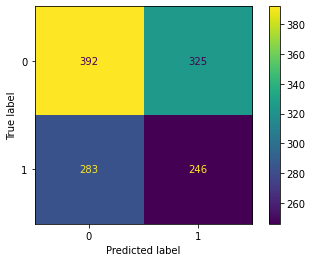

In [71]:
cmd = ConfusionMatrixDisplay(bitcoin_model.confusion_matrix())
cmd.plot()
plt.show()

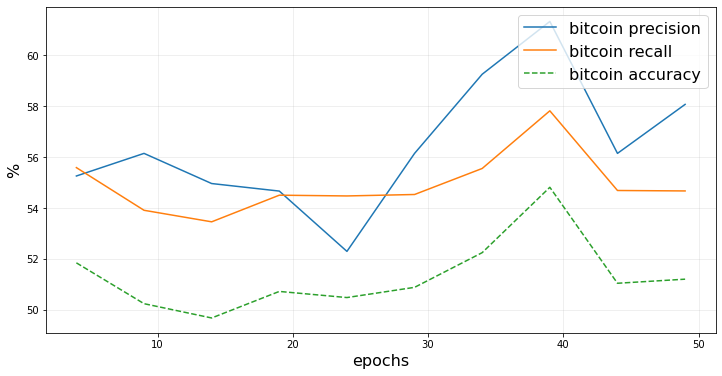

In [67]:
# iterate through 50 epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

epochs = [x for x in range(4,51,5)]

# bitcoin
ax.plot(epochs, bitcoin_model.precision, label='bitcoin precision')
ax.plot(epochs, bitcoin_model.recall, label='bitcoin recall')
ax.plot(epochs, bitcoin_model.accuracy, '--', label='bitcoin accuracy')

ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("%", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

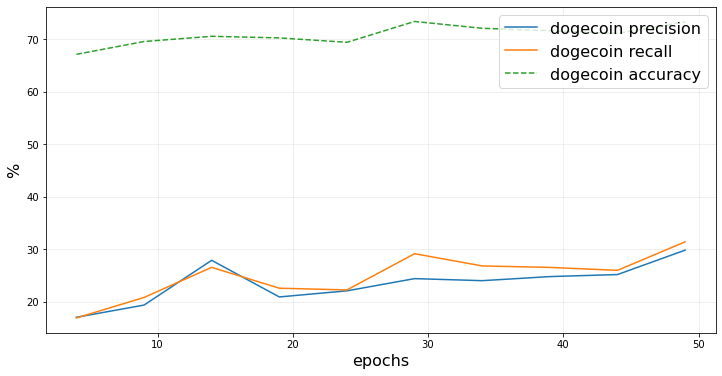

In [68]:
# iterate through 50 epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

epochs = [x for x in range(4,51,5)]

# dogecoin
ax.plot(epochs, dogecoin_model.precision, label='dogecoin precision')
ax.plot(epochs, dogecoin_model.recall, label='dogecoin recall')
ax.plot(epochs, dogecoin_model.accuracy, '--', label='dogecoin accuracy')

ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("%", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

In [54]:
bitcoin_relu = Net(X_train_b.shape[1], nn.ReLU())
bitcoin_relu.train(X_train_b, y_train_b, X_valid_b, y_valid_b, num_epochs = 50)

epoch   5/ 50:   train loss:   46.629  validation loss:   46.154
epoch  10/ 50:   train loss:   47.352  validation loss:   43.590
epoch  15/ 50:   train loss:   48.475  validation loss:   49.038
epoch  20/ 50:   train loss:   44.703  validation loss:   44.872
epoch  25/ 50:   train loss:   47.796  validation loss:   44.551
epoch  30/ 50:   train loss:   46.648  validation loss:   46.795
epoch  35/ 50:   train loss:   47.271  validation loss:   47.115
epoch  40/ 50:   train loss:   46.629  validation loss:   45.513
epoch  45/ 50:   train loss:   47.138  validation loss:   44.551
epoch  50/ 50:   train loss:   49.037  validation loss:   41.987


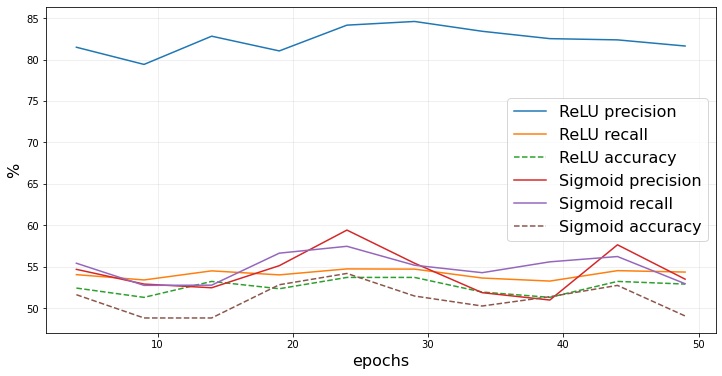

In [55]:
# iterate through 50 epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

epochs = [x for x in range(4,51,5)]

# dogecoin relu
ax.plot(epochs, bitcoin_relu.precision, label='ReLU precision')
ax.plot(epochs, bitcoin_relu.recall, label='ReLU recall')
ax.plot(epochs, bitcoin_relu.accuracy, '--', label='ReLU accuracy')

# dogecoin sigmoid
ax.plot(epochs, bitcoin_model.precision, label='Sigmoid precision')
ax.plot(epochs, bitcoin_model.recall, label='Sigmoid recall')
ax.plot(epochs, bitcoin_model.accuracy, '--', label='Sigmoid accuracy')

ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("%", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="center right", fontsize=16);

In [59]:
features = FINANCIAL_FEATURES

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, timeout=60)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-01 16:31:45,106] A new study created in memory with name: no-name-19315d4c-0829-4e3b-9b62-b95dd09613bd
[I 2022-06-01 16:31:45,652] Trial 0 finished with value: 0.6842867136001587 and parameters: {'n_layers': 1, 'n_units_l0': 7, 'dropout_l0': 0.2937876447856613, 'optimizer': 'RMSprop', 'lr': 0.049807810224510814}. Best is trial 0 with value: 0.6842867136001587.
[I 2022-06-01 16:31:46,172] Trial 1 finished with value: 0.6897882223129272 and parameters: {'n_layers': 1, 'n_units_l0': 28, 'dropout_l0': 0.28026128736967887, 'optimizer': 'Adam', 'lr': 0.000227031957028142}. Best is trial 0 with value: 0.6842867136001587.
[I 2022-06-01 16:31:46,721] Trial 2 finished with value: 0.8153231143951416 and parameters: {'n_layers': 2, 'n_units_l0': 61, 'dropout_l0': 0.2329211148908402, 'n_units_l1': 4, 'dropout_l1': 0.2010904991398996, 'optimizer': 'RMSprop', 'lr': 4.4952696794084176e-05}. Best is trial 0 with value: 0.6842867136001587.
[I 2022-06-01 16:31:47,271] Trial 3 finished with val

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  9
  Number of complete trials:  16
Best trial:
  Value:  0.6687139272689819
  Params: 
    n_layers: 2
    n_units_l0: 66
    dropout_l0: 0.4016166418145083
    n_units_l1: 50
    dropout_l1: 0.32495430320799235
    optimizer: Adam
    lr: 0.0042500695855302115


In [65]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data)
        nn.init.normal_(m.bias.data)

class Net(nn.Module):

    def __init__(self, size, activation = nn.Sigmoid()):
        super(Net, self).__init__()
        layers = []
        
        # first layer
        layers.append(nn.Linear(size, 66))
        #layers.append(nn.Sigmoid())
        layers.append(activation)
        layers.append(nn.Dropout(0.4016166418145083))
        
        # second layer
        layers.append(nn.Linear(66, 50))
        #layers.append(nn.Sigmoid())
        layers.append(activation)
        layers.append(nn.Dropout(0.32495430320799235))
        
        # output layer    
        layers.append(nn.Linear(50, CLASSES))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        self.model.apply(init_weights)
        
        self.pred = []
        self.true_y = []
        
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.train_loss = []
        self.valid_loss = []

    def forward(self, x):
        return self.model(x)

    def train(self, X_train, y_train, X_valid=None, y_valid=None,
          eta=0.0042500695855302115, num_epochs=10):
        """
        Train the network with SGD

        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded labels 

        """
        criterion = nn.BCELoss()
        #optimizer = optim.SGD(self.parameters(), lr=eta)
        optimizer = optim.Adam(self.parameters(), lr=eta)
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        # loop over training epochs 
        for ep in range(1, num_epochs+1):

            # shuffle indices 
            np.random.shuffle(shuffled_inds)

            # loop over training examples 
            for ind in shuffled_inds:
                optimizer.zero_grad()
                output = self.forward(X_train[ind])
                #output = torch.round(output)
                loss = criterion(output,y_train[ind])
                loss.backward() 
                optimizer.step()
            
            if (ep % 5) == 0:
                train_loss = self.compute_loss(X_train, y_train)
                self.train_loss.append(train_loss)
                valid_loss = self.compute_loss(X_valid, y_valid)
                self.valid_loss.append(valid_loss)
                accuracy = self.compute_accuracy(X_train, y_train)
                self.accuracy.append(accuracy)
                prec = self.compute_precision()
                self.precision.append(prec)
                recall = self.compute_recall()
                self.recall.append(recall)

    def compute_accuracy(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        # reset self.pred and self.true_y
        if self.pred:
            self.pred = []
            self.true_y = []
        
        acc = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            output = self.forward(x)
            #if output >= y_train.sum() / y_train.shape[0]:
            #    y_hat = torch.Tensor([1])
            #else:
            #    y_hat = torch.Tensor([0])
            y_hat = torch.round(output)[0]
            self.pred.append(y_hat.item())
            self.true_y.append(t.item())
            if y_hat == t:
                acc += 1
        return acc / X.shape[0] * 100
    
    def compute_loss(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        
        loss = 0
        
        criterion = nn.BCELoss()
        for x, t in zip(X, y):
            output = self.forward(x)
            loss += criterion(output, t).item()
        return loss / X.shape[0]
        #output = self.forward(X)
        #return criterion(output, y)
    
    def confusion_matrix(self):
        return confusion_matrix(self.pred, self.true_y, labels = [1, 0])
    
    def compute_precision(self):
        conf_matrix = self.confusion_matrix()
        return conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0]) * 100
    
    def compute_recall(self):
        conf_matrix = self.confusion_matrix()
        return conf_matrix[0][0] / conf_matrix[0].sum() * 100

In [ ]:
X_train_b, y_train_b = get_df(bitcoin_train, FINANCIAL_FEATURES)
X_valid_b, y_valid_b = get_df(bitcoin_test, FINANCIAL_FEATURES)
X_train_d, y_train_d = get_df(dogecoin_train, FINANCIAL_FEATURES)
X_valid_d, y_valid_d = get_df(dogecoin_test, FINANCIAL_FEATURES)

In [66]:
bit_fin_model = Net(X_train_b.shape[1])
doge_fin_model = Net(X_train_d.shape[1])